In [28]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import rowcol

def load_dem(tif_path):
    with rasterio.open(tif_path) as src:
        dem = src.read(1)
        transform = src.transform
        crs = src.crs
    return dem, transform, crs

def latlon_to_rowcol(lat, lon, transform, crs):
    import rasterio.warp
    xs, ys = rasterio.warp.transform('EPSG:4326', crs, [lon], [lat])
    x, y = xs[0], ys[0]
    row, col = rowcol(transform, x, y)
    return int(row), int(col)

def get_elevation_profile(dem, observer_pos, azimuth, h_fov, samples=1000):
    rows, cols = dem.shape
    obs_row, obs_col = observer_pos

    start_angle = azimuth - h_fov / 2
    end_angle = azimuth + h_fov / 2
    angles = np.linspace(start_angle, end_angle, samples)

    max_dist = int(np.sqrt(rows**2 + cols**2))

    elevation_profile = np.zeros((samples, max_dist))
    distance_profile = np.zeros((samples, max_dist))

    for i, angle in enumerate(angles):
        math_angle = 90 - angle
        rad = np.radians(math_angle)

        for d in range(1, max_dist):
            row = int(obs_row - d * np.sin(rad))
            col = int(obs_col + d * np.cos(rad))

            if 0 <= row < rows and 0 <= col < cols:
                elevation_profile[i, d] = dem[row, col]
                distance_profile[i, d] = d
            else:
                break

    return elevation_profile, distance_profile

def calculate_viewing_angles(elevation_profile, distance_profile, observer_elevation):
    viewing_angles = np.zeros_like(elevation_profile)

    for i in range(elevation_profile.shape[0]):
        for j in range(elevation_profile.shape[1]):
            if distance_profile[i, j] > 0:
                height_diff = elevation_profile[i, j] - observer_elevation
                dist = distance_profile[i, j]
                viewing_angles[i, j] = np.degrees(np.arctan2(height_diff, dist))

    return viewing_angles

def render_horizon(elevation_profile, distance_profile, observer_elevation, v_fov=60, width=1920, height=1080):
    viewing_angles = calculate_viewing_angles(elevation_profile, distance_profile, observer_elevation)

    img = np.ones((height, width), dtype=np.float32)   # white sky
    depth_map = np.zeros((height, width), dtype=np.float32)

    v_min = -10
    v_max = v_min + v_fov

    for h_idx in range(elevation_profile.shape[0]):
        col = int((h_idx / elevation_profile.shape[0]) * width)
        col = min(col, width - 1)

        max_angle = -np.inf
        horizon_dist = 0

        for d_idx in range(elevation_profile.shape[1]):
            if distance_profile[h_idx, d_idx] > 0:
                angle = viewing_angles[h_idx, d_idx]
                if angle > max_angle:
                    max_angle = angle
                    horizon_dist = distance_profile[h_idx, d_idx]

        if v_min <= max_angle <= v_max:
            row = int((1 - (max_angle - v_min) / v_fov) * height)
            if 0 <= row < height:
                img[row:, col] = 0.0        # black terrain
                depth_map[row:, col] = horizon_dist

    return img, depth_map

def render_horizon_view(tif_file, lat, lon, azimuth=0, h_fov=200, v_fov=60):
    dem, transform, crs = load_dem(tif_file)
    obs_row, obs_col = latlon_to_rowcol(lat, lon, transform, crs)

    rows, cols = dem.shape
    if not (0 <= obs_row < rows and 0 <= obs_col < cols):
        raise ValueError("Observer outside DEM bounds")

    observer_elevation = dem[obs_row, obs_col] + 1.7

    elevation_profile, distance_profile = get_elevation_profile(
        dem, (obs_row, obs_col), azimuth, h_fov
    )

    img, depth_map = render_horizon(
        elevation_profile, distance_profile, observer_elevation,
        v_fov, width=1920, height=1080
    )

    # Display final non-blurred image
    plt.figure(figsize=(16, 9))
    plt.imshow(img, cmap='gray', aspect='auto', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Horizon View - Lat={lat}, Lon={lon}, Azimuth={azimuth}°')
    plt.tight_layout()
    plt.show()

    return img


In [2]:
from google.colab import files
uploaded = files.upload()

Saving tile_Vr9AytLJtkk_band2.tif to tile_Vr9AytLJtkk_band2.tif


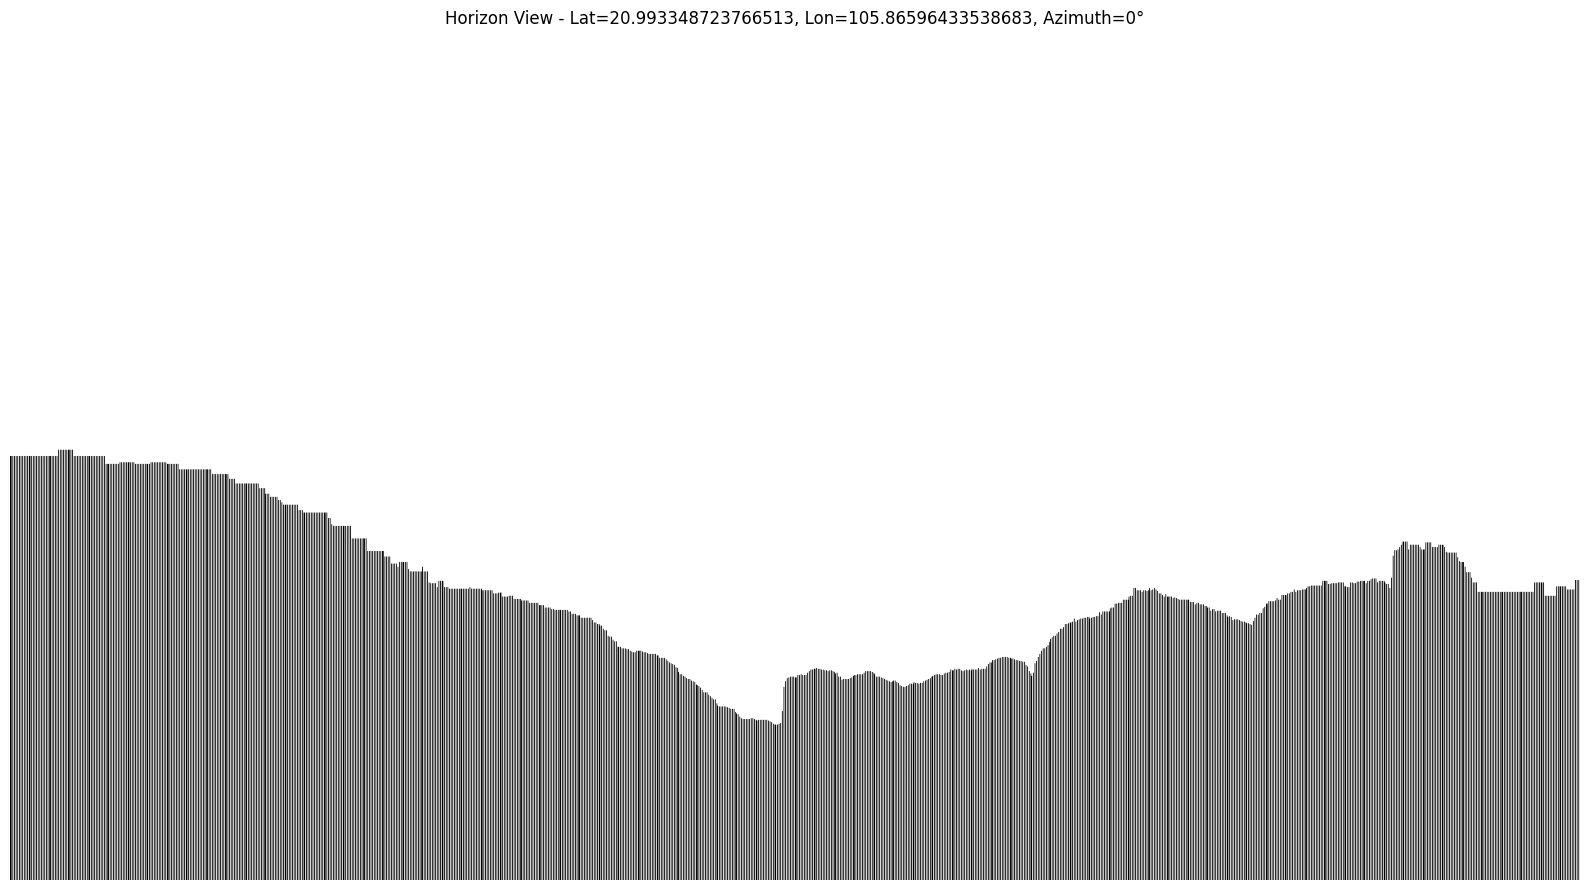

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.]], dtype=float32)

In [30]:
render_horizon_view(
    '/content/tile_Vr9AytLJtkk_band2.tif',
    lat=20.993348723766513,
    lon=105.86596433538683,
    azimuth=0,
    h_fov=200,
    v_fov=60,
)